# Lecture 5 Conversion Analysis on Web Design

## 1. Introduction
For this project, we will be analyzing the results of an A/B test run by an e-commerce website.  The final goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision

## 2. Import data & data cleaning

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [10]:
df=pd.read_csv('Copy of sample ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,1
3,853541,28:03.1,treatment,new_page,1
4,864975,52:26.2,control,old_page,1


Get an overview of the dataset

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


Check if `group` aligns with `landing_page`

In [12]:
((df.group=='treatment') & (df.landing_page=='old_page')).sum()

1965

In [13]:
((df.group=='control') & (df.landing_page=='new_page')).sum()

1928

In [14]:
df['misaligned']=((df.group=='treatment') & (df.landing_page=='old_page')) | ((df.group=='control') & (df.landing_page=='new_page'))
df = df[-df['misaligned']] # show rows with False in misagligned

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290585 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
 5   misaligned    290585 non-null  bool  
dtypes: bool(1), int64(2), object(3)
memory usage: 13.6+ MB


Check unique users

In [16]:
df.user_id.nunique()

290584

In [17]:
df['user_id'].value_counts().sort_values(ascending=False).head()

user_id
773192    2
834487    1
936923    1
679687    1
719014    1
Name: count, dtype: int64

# make assumption:
## let's assume

In [18]:
df[df['user_id']==773192]

,user_id,timestamp,group,landing_page,converted,misaligned
1899,773192,37:58.8,treatment,new_page,1,False
2893,773192,55:59.6,treatment,new_page,0,False


In [19]:
df.drop(1899, axis = 0,inplace = True)

In [20]:
df['user_id'].value_counts().sort_values(ascending=False).head()

user_id
851104    1
834487    1
936923    1
679687    1
719014    1
Name: count, dtype: int64

How many users in each group

In [21]:
df[['user_id','group']].groupby('group').count()

,user_id
group,
control,145274
treatment,145310


Conversion rate in each group

In [22]:
df[['user_id','group','converted']].groupby('group').agg({'user_id':'count','converted':'mean', 'converted':'sum'})

,user_id,converted
group,,
control,145274,17489
treatment,145310,18215


## 3. Analyze results

Let's assume that the new page does not have higher conversion rate than the old page at 5% Type I error. So the hypothesis woule be:

**null:** **$p_{new}$** - **$p_{old}$** <=0

**alternative:** **$p_{new}$** - **$p_{old}$** >0

In [23]:
convert_old = df[df.group=='control'].converted.sum()
convert_new = df[df.group=='treatment'].converted.sum()
n_old = len(df[df.group=='control'].converted)
n_new= len(df[df.group=='treatment'].converted)

convert_old, convert_new, n_old, n_new

(17489, 18215, 145274, 145310)

In [24]:
conversion_dic = {'Views':{'Control':n_old,'Test':n_new},'Converts': {'Control':convert_old,'Test':convert_new}}
conversion_table = pd.DataFrame(conversion_dic)
conversion_table['Conversion %'] = conversion_table['Converts'] / conversion_table['Views']
conversion_table['Conversion %'] = conversion_table['Conversion %'].apply(lambda x: str(np.round(x,3)*100)+'%')
conversion_table

,Views,Converts,Conversion %
Control,145274,17489,12.0%
Test,145310,18215,12.5%


### 3.1 Z-test in our way

In [25]:
def z_test(p1,p0,n1,n0):
    delta = p1-p0
    p = (p1*n1 + p0*n0) / (n1+n0)
    return delta / np.sqrt(p*(1-p)*(1/n1 + 1/n0))

In [26]:
p1 = convert_new / n_new
p0 = convert_old / n_old
n1 = n_new
n0 = n_old

In [27]:
z_value = z_test(p1,p0,n1,n0)
z_value

4.077481782861739

In [28]:
from scipy.stats import norm
p_value = 1- norm.cdf(z_value)

p_value

2.276304781123617e-05

p-value is less than 0.05, so we can reject null hypothesis and accept alternative hypothesis that
<br>**$p_{new}$** - **$p_{old}$** >0, the new page has higher conversion rate than the old page

### 3.2 Z-test in Statsmodels

In [29]:
import statsmodels.api as sm

In [30]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(4.077481782861739, 2.276304781118429e-05)

p-value is less than 0.05, so we can reject null hypothesis and accept alternative hypothesis that
<br>**$p_{new}$** - **$p_{old}$** >0, the new page has higher conversion rate than the old page

# bonus - > eda - line plot 2 color control vs treatment

In [34]:
# Extract hour from timestamp and create a now column called hour
df['hour'] = df['timestamp'].str.split(':').str[0].astype(int)
df


,user_id,timestamp,group,landing_page,converted,misaligned,hour
0,851104,11:48.6,control,old_page,0,False,11
1,804228,01:45.2,control,old_page,0,False,1
2,661590,55:06.2,treatment,new_page,1,False,55
3,853541,28:03.1,treatment,new_page,1,False,28
4,864975,52:26.2,control,old_page,1,False,52
...,...,...,...,...,...,...,...
294473,751197,28:38.6,control,old_page,0,False,28
294474,945152,51:57.1,control,old_page,0,False,51
294475,734608,45:03.4,control,old_page,0,False,45
294476,697314,20:29.0,control,old_page,0,False,20


In [43]:
# Calculate conversion rates for each group
conversion_rate = df.groupby(['hour', 'group'])['converted'].mean().unstack()
conversion_rate

group,control,treatment
hour,,
0,0.118893,0.122311
1,0.128778,0.116889
2,0.119730,0.127769
3,0.125789,0.131134
4,0.124138,0.110793
5,0.123935,0.128782
6,0.121355,0.132999
7,0.121456,0.116079
8,0.110890,0.124587


# plot the graph

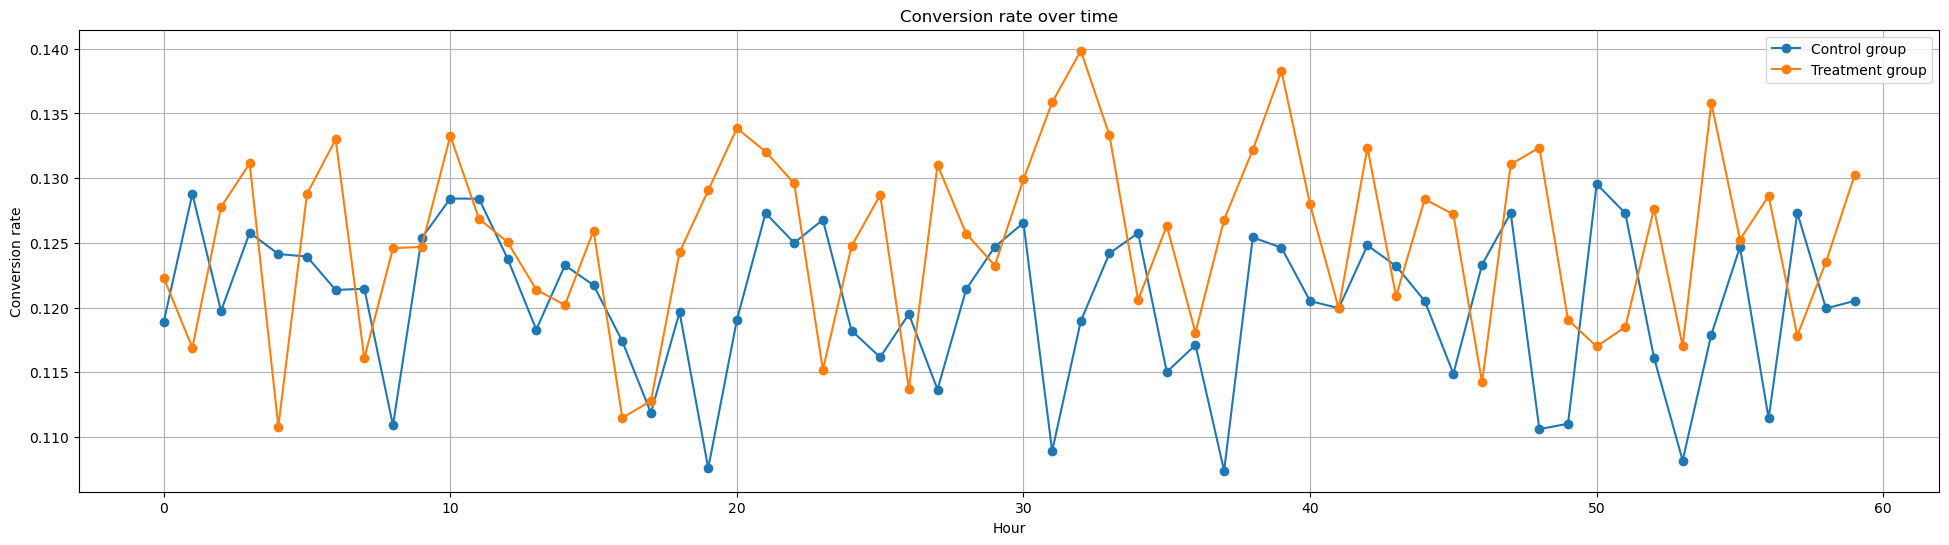

In [47]:
import matplotlib.pyplot as plt
plt.figure(figsize=(24,6))
plt.plot(conversion_rate.index, conversion_rate['control'], label='Control group',marker='o')
plt.plot(conversion_rate.index, conversion_rate['treatment'],label='Treatment group', marker = 'o')
plt.xlabel('Hour')
plt.ylabel('Conversion rate')
plt.title('Conversion rate over time')
plt.legend()
plt.grid(True)
plt.show()